<a href="https://colab.research.google.com/github/cpyp-ipdp/pgd_cdmx/blob/main/indicadores/vivienda/indicadores_vivienda_pgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Estimación de indicadores de vivienda para el Plan General de Desarrollo de la Ciudad de México

En este script se descargan los microdatos de la Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH) para los años 2016, 2018, 2020 y 2022. Posteriormente, se estiman dos indicadores de vivienda para la Ciudad de México: rezago habitacional y viviendas sin escrituras. Los resultados se presentan en dos cuadros.

In [1]:
##Estimación de indicadores de vivienda
#Se borra todo lo que se encuentra en el entorno

#rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, showtext, srvyr,archive, showtext,foreign)
#Cargar fuente
font_add_google("Noto sans", "noto")
showtext_auto()

remotes::install_github("cpyp-ipdp/funcionespgd", force = TRUE)
library(funcionespgd)

Cargando paquete requerido: pacman

Using GitHub PAT from the git credential store.




rlang  (1.1.4 -> 1.1.6) [CRAN]
glue   (1.7.0 -> 1.8.0) [CRAN]
cli    (3.6.3 -> 3.6.5) [CRAN]
tibble (3.2.1 -> 3.3.0) [CRAN]


Installing 4 packages: rlang, glue, cli, tibble

Warning message:
"package 'tibble' is in use and will not be installed"
Installing packages into 'C:/Users/claud/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'rlang' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'rlang'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\rlang\libs\x64\rlang.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\rlang\libs\x64\rlang.dll: Permission denied"
Warning message:
"restored 'rlang'"


package 'glue' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'glue'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\glue\libs\x64\glue.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\glue\libs\x64\glue.dll: Permission denied"
Warning message:
"restored 'glue'"


package 'cli' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'cli'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\cli\libs\x64\cli.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\cli\libs\x64\cli.dll: Permission denied"
Warning message:
"restored 'cli'"



The downloaded binary packages are in
	C:\Users\claud\AppData\Local\Temp\Rtmp8klsc1\downloaded_packages
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file 'C:\Users\claud\AppData\Local\Temp\Rtmp8klsc1\remotes1a043a7476b9\cpyp-ipdp-funcionespgd-594f916/DESCRIPTION' ... OK
* preparing 'funcionespgd':
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted 'LazyData' from DESCRIPTION
* building 'funcionespgd_0.1.0.tar.gz'



Installing package into 'C:/Users/claud/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



In [2]:
#Crear directorio para guardar los archivos
dir.create("data", showWarnings = FALSE)

In [3]:
url_basica<-"https://www.inegi.org.mx/contenidos/programas/enigh/nc/"
segunda_parte<-"microdatos/enigh"
fin<-"_ns_viviendas_csv.zip"

In [4]:
years<-c("2016", "2018", "2020", "2022")

In [5]:
# Descargar los archivos, descomprimirlos y renombrarlos
for (i in 1:length(years)) {
  url <- paste0(url_basica, years[i], "/", segunda_parte, years[i], fin)
  destfile <- paste0("data/", years[i], fin)

  # Descargar el archivo
  download.file(url, destfile = destfile)

  # Descomprimir el archivo
  unzip(destfile, exdir = "data")

  # Renombrar el archivo descomprimido a "viviendas_xxxx.csv"
  file.rename(
    from = "data/viviendas.csv",
    to = paste0("data/viviendas_", years[i], ".csv")
  )
}

In [6]:
#Enlistar archivos de la carpeta data
list.files("data")

[1] "2016_ns_viviendas_csv.zip"         "2018_ns_viviendas_csv.zip"        
 [3] "2020_ns_viviendas_csv.zip"         "2022_ns_viviendas_csv.zip"        
 [5] "nota_bases_datos_enigh2016_ns.txt" "nota_bases_datos_enigh2018_ns.txt"
 [7] "viviendas_2016.csv"                "viviendas_2018.csv"               
 [9] "viviendas_2020.csv"                "viviendas_2022.csv"

### Función de estimación

In [7]:
estimacion <- function(path, variable) {
  # Cargar los datos
  print(path)
  datos <- read_csv(path)

  datos <- datos %>%
    mutate(
      across(starts_with("mat") & where(is.character),
             ~ replace_na(parse_number(.x, na = c('', 'NA', '&')), 0)),
      rezago = if_else(
        ((tot_resid / num_cuarto) > 2.5) |
          (mat_pared %in% 1:6) |
          (mat_techos %in% c(1:4, 6, 7, 9)) |
          (mat_pisos == 1) |
          (excusado == 2),
        "En rezago",
        "Fuera de rezago"
      )
    ) %>%
    mutate(cve_ent = case_when(
      nchar(folioviv) == 9  ~ paste0("0", substr(folioviv, 1, 1)),
      nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
    )) %>%
    # Filtrar si entidad es 9
  filter(cve_ent == "09")


  # Definir diseño muestral
  mydesign <- datos %>%
    as_survey_design(ids = upm,
                     strata = est_dis,
                     weights = factor)

  # Estimar rezago habitacional
  rezago <- mydesign %>%
    group_by(rezago) %>%
    summarise(
      viviendas = survey_total(vartype = "cv"),
      pct = survey_prop(vartype = "cv")
        #Viviendas totales
    ) %>%
    mutate(pct = round(pct * 100, 2)) %>%
  # Añadir columna con el total de viviendas
  mutate(total_viviendas = sum(viviendas)) %>%
    filter(rezago == "En rezago") %>%
    # Añadir año
    mutate(year = substr(path, 16, 19))




  # Estimar viviendas sin escrituras
  escrituras <- mydesign %>%
    filter(tenencia %in% c(3,4)) %>%
group_by(escrituras) %>%
    summarise(
      viviendas = survey_total(vartype = "cv"),
      pct = survey_prop(vartype = "cv")
    ) %>%
 mutate(total_viviendas = sum(viviendas)) %>%
    filter(escrituras == 3) %>%
    mutate(pct = round(pct * 100, 2),
           escrituras = case_when(
        escrituras == 3 ~ "Sin escrituras"
))%>%
mutate(year = substr(path, 16, 19))


#Hogares en la vivienda

hogares<-mydesign %>%
summarise(
    hogares=survey_total(tot_hog, vartype = "cv")
    ) %>%
mutate(year = substr(path, 16, 19))


##Hogares hacinamiento

hogares_hac<-mydesign %>%
#Identificar hacinamiento
mutate(hacinamiento=ifelse((tot_resid/num_cuarto)>2.5,1,0))%>%
#filtrar hacinamiento
#filter(hacinamiento==1)%>%
group_by(hacinamiento)%>%
summarise(
    hogares_hac=survey_total(vartype = "cv"),
    pct=survey_prop(vartype = "cv")
    ) %>%
mutate(year = substr(path, 16, 19))%>%

mutate(pct=round(pct*100,2))


hogares_hac2<-mydesign %>%
#Identificar hacinamiento
mutate(hacinamiento=ifelse((tot_resid/num_cuarto)>2,1,0))%>%
#filtrar hacinamiento
#filter(hacinamiento==1)%>%
group_by(hacinamiento)%>%
summarise(
    hogares_hac=survey_total(vartype = "cv"),
    pct=survey_prop(vartype = "cv")
    ) %>%
mutate(year = substr(path, 16, 19))%>%
mutate(pct=round(pct*100,2))


#Hog hacinamiento no propietarios
hogares_hac_no_prop<-mydesign%>%
#Identificar hacinamiento
mutate(hacinamiento=ifelse((tot_resid/num_cuarto)>2.5,1,0))%>%
mutate(ten_vivi=case_when(tenencia==3 | tenencia==4 ~ "Propietarios",
            TRUE ~ "No propietarios"))%>%
#filtrar hacinamiento
filter(hacinamiento==1)%>%
group_by(ten_vivi)%>%
#Contar hogares con hacinamiento
summarise(
    hogares_hac=survey_prop(vartype = "cv")
    ) %>%
ungroup()%>%
mutate(year = as.integer(substr(path, 16, 19)))%>%
filter(ten_vivi=="No propietarios")%>%
mutate(hogares_hac=round(hogares_hac*100,2))



  # Devolver el resultado basado en la variable
  if (variable == "rezago") {
    return(rezago)

  } else if (variable == "sin_escrituras") {
    return(escrituras)
  }

else if (variable == "hogares") {
    return(hogares)
  }

  else if (variable == "hogares_hac_no_prop") {
    return(hogares_hac_no_prop)
}

else if (variable == "hogares_hac") {
    return(hogares_hac)

  }
    else if (variable == "hogares_hac2") {
        return(hogares_hac2)

    }

else {
    stop("Variable no reconocida. Use 'rezago' o 'sin_escrituras'.")
  }}

In [8]:
#Construir cuadros de rezago habitacional

tabla_rezago<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "viviendas_.*.csv"),
  
  estimacion,
  variable = "rezago"
)%>%
mutate(year = as.integer(year))
print("Porcentaje de viviendas cuyos habitantes viven en rezago habitacional")
tabla_rezago


[1] "data/viviendas_2016.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 69169 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (54): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2018.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 73405 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2020.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 87754 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2022.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 88823 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Porcentaje de viviendas cuyos habitantes viven en rezago habitacional"


rezago,viviendas,viviendas_cv,pct,pct_cv,total_viviendas,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
En rezago,272200,0.08809435,9.81,0.08684886,2774780,2016
En rezago,218501,0.08906203,8.02,0.08727815,2724389,2018
En rezago,198021,0.08360376,7.31,0.08292165,2707156,2020
En rezago,175242,0.09933936,5.94,0.09870452,2947953,2022


In [9]:
#Construir cuadros de viviendas sin escrituras
#Viviendas sin escrituras corresponden a viviendas propias y propias que se están pagando y no cuentan con escrituras

tabla_escrituras<-map_dfr(
    list.files("data", full.names = TRUE, pattern = "viviendas_.*.csv"),
    estimacion,
    variable = "sin_escrituras"
    )%>%
    mutate(
  year = as.integer(year)
)
print("Porcentaje de viviviendas propias o propias en proceso de pago que no cuentan con escrituras")
tabla_escrituras

[1] "data/viviendas_2016.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 69169 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (54): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2018.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 73405 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2020.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 87754 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2022.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 88823 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Porcentaje de viviviendas propias o propias en proceso de pago que no cuentan con escrituras"


escrituras,viviendas,viviendas_cv,pct,pct_cv,total_viviendas,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Sin escrituras,266547,0.08646642,17.71,0.08298775,1505322,2016
Sin escrituras,246283,0.09985847,17.22,0.09461881,1429942,2018
Sin escrituras,259056,0.09464920,16.23,0.08765464,1595765,2020
Sin escrituras,310191,0.08428046,17.63,0.07835935,1759030,2022


In [10]:
tabla_hogares<-map_dfr(
    list.files("data", full.names = TRUE, pattern = "viviendas_.*.csv"),
    estimacion,
    variable = "hogares"
    )%>%
mutate(
  year = as.integer(year),
tasa_crec=(hogares/lag(hogares)-1)*100)
tabla_hogares

[1] "data/viviendas_2016.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 69169 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (54): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2018.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 73405 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2020.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 87754 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2022.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 88823 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hogares,hogares_cv,year,tasa_crec
<dbl>,<dbl>,<int>,<dbl>
2825100,0.01357273,2016,NA
2778842,0.01510168,2018,-1.637393
2731683,0.01285271,2020,-1.697074
2990030,0.01388237,2022,9.457430


In [11]:
tabla_hogares_hac<-map_dfr(
    list.files("data", full.names = TRUE, pattern = "viviendas_.*.csv"),
    estimacion,
    variable="hogares_hac"
    )%>%
mutate(
  year = as.integer(year),
  #asa_crec = (hogares_hac / lag(hogares_hac) - 1) * 100
)%>%
filter(hacinamiento==1)
print("Porcentaje de hogares en hacinamiento")
tabla_hogares_hac

[1] "data/viviendas_2016.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 69169 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (54): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2018.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 73405 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2020.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 87754 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2022.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 88823 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Porcentaje de hogares en hacinamiento"


hacinamiento,hogares_hac,hogares_hac_cv,pct,pct_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,94467,0.1494674,3.40,0.1489454,2016
1,69444,0.1668508,2.55,0.1655767,2018
1,79858,0.1226073,2.95,0.1215774,2020
1,50615,0.1625358,1.72,0.1624582,2022


In [12]:
tabla_hogares_hac2<-map_dfr(
    list.files("data", full.names = TRUE, pattern = "viviendas_.*.csv"),
    estimacion,
    variable="hogares_hac2"
    )%>%
mutate(
  year = as.integer(year),
  #asa_crec = (hogares_hac / lag(hogares_hac) - 1) * 100
)%>%
filter(hacinamiento==1)
print("Porcentaje de hogares en hacinamiento considerando relación de 2 o más personas por cuarto")
tabla_hogares_hac2

[1] "data/viviendas_2016.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 69169 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (54): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2018.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 73405 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2020.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 87754 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2022.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 88823 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Porcentaje de hogares en hacinamiento considerando relación de 2 o más personas por cuarto"


hacinamiento,hogares_hac,hogares_hac_cv,pct,pct_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,138376,0.12600871,4.99,0.12602813,2016
1,113820,0.12485900,4.18,0.12388585,2018
1,123329,0.09333855,4.56,0.09224503,2020
1,82588,0.12711455,2.80,0.12692183,2022


In [13]:
tabla_hogares_hac_no_prop<-map_dfr(
    list.files("data", full.names = TRUE, pattern = "viviendas_.*.csv"),
    estimacion,
    variable="hogares_hac_no_prop"
    )
print("Porcentaje de hogares en hacinamiento que no son propietarios de la vivienda")
tabla_hogares_hac_no_prop

[1] "data/viviendas_2016.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 69169 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (54): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2018.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 73405 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2020.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 87754 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2022.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 88823 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Porcentaje de hogares en hacinamiento que no son propietarios de la vivienda"


ten_vivi,hogares_hac,hogares_hac_cv,year
<chr>,<dbl>,<dbl>,<int>
No propietarios,81.57,0.07178577,2016
No propietarios,83.33,0.06234368,2018
No propietarios,78.57,0.06250299,2020
No propietarios,72.08,0.10327248,2022


#### Proyecciones a 2045

Se seleccionan dos indicadores: porcentaje de rezago habitacional y tenencia de escrituras

In [14]:
tabla_rezago

rezago,viviendas,viviendas_cv,pct,pct_cv,total_viviendas,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
En rezago,272200,0.08809435,9.81,0.08684886,2774780,2016
En rezago,218501,0.08906203,8.02,0.08727815,2724389,2018
En rezago,198021,0.08360376,7.31,0.08292165,2707156,2020
En rezago,175242,0.09933936,5.94,0.09870452,2947953,2022


In [15]:
tcma_rezago<-((tabla_rezago$pct[tabla_rezago$year==2022]/tabla_rezago$pct[tabla_rezago$year==2016])^(1/(2022-2016))-1)

tcma_rezago

[1] -0.08021518

In [16]:
extendido_rezago<-data.frame(year=2023:2045)
extendido_rezago$pct<-tabla_rezago$pct[tabla_rezago$year==2022]*cumprod(rep(1+tcma_rezago,length(2023:2045)))
extendido_rezago%>%
mutate(pct=round(pct,2))

year,pct
<int>,<dbl>
2023,5.46
2024,5.03
2025,4.62
2026,4.25
2027,3.91
2028,3.60
2029,3.31
2030,3.04
2031,2.80


In [17]:
tabla_escrituras

escrituras,viviendas,viviendas_cv,pct,pct_cv,total_viviendas,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Sin escrituras,266547,0.08646642,17.71,0.08298775,1505322,2016
Sin escrituras,246283,0.09985847,17.22,0.09461881,1429942,2018
Sin escrituras,259056,0.09464920,16.23,0.08765464,1595765,2020
Sin escrituras,310191,0.08428046,17.63,0.07835935,1759030,2022


In [18]:
tcma_esc<-((tabla_escrituras$pct[tabla_escrituras$year==2020]/tabla_escrituras$pct[tabla_escrituras$year==2016])^(1/(2022-2016))-1)

tcma_esc

[1] -0.01443942

In [19]:
extendido_escrituras<-data.frame(year=2023:2045)
extendido_escrituras$pct<-tabla_escrituras$pct[tabla_escrituras$year==2022]*cumprod(rep(1+tcma_esc,length(2023:2045)))
extendido_escrituras%>%
mutate(pct=round(pct,2))

year,pct
<int>,<dbl>
2023,17.38
2024,17.12
2025,16.88
2026,16.63
2027,16.39
2028,16.16
2029,15.92
2030,15.69
2031,15.47


### Escenarios

In [20]:

prueba_desc<-tabla_rezago%>%
select(year, pct)%>%
intervals("pct", margen = 0, año_base = 2022)


extendido_rezago_int<-extendido_rezago%>%
intervals("pct", margen = 0.015, año_base = 2022)



prueba_desc<-prueba_desc%>%
bind_rows(extendido_rezago_int)
prueba_desc


year,estimado,superior,inferior
<dbl>,<dbl>,<dbl>,<dbl>
2016,9.8100000,9.810000,9.8100000
2018,8.0200000,8.020000,8.0200000
2020,7.3100000,7.310000,7.3100000
2022,5.9400000,5.940000,5.9400000
2023,5.4635219,5.545475,5.3827802
2024,5.0252645,5.177153,4.8778320
2025,4.6221620,4.833295,4.4202521
2026,4.2513945,4.512275,4.0055968
2027,3.9103681,4.212577,3.6298396


In [21]:
grafica_cool <- function(data, x, y,
                         titulo = "Mi gráfico de línea bonito",
                         linea_vertical = NULL,
                         mostrar_intervalo = c("ninguno", "ambos", "superior", "inferior"),
                         fuente = NULL,
                         etiqueta_x = NULL,
                         etiqueta_y = NULL,
                         mostrar_leyenda = FALSE,
                         ano_base = NULL,
                         mostrar_etiqueta_ano_base = TRUE,
                         anios_etiquetas = c(2030, 2035, 2045),
                         nombre_observado = "Observado",
                         nombre_estimado_futuro = "Deseable",
                         nombre_intervalo_superior = "Escenario alto",
                         nombre_intervalo_inferior = "Escenario bajo",
                         titulo_leyenda = "Escenarios",
                         limite_inferior_y = 0) {
  
  mostrar_intervalo <- match.arg(mostrar_intervalo)
  
  if (is.null(etiqueta_x)) etiqueta_x <- x
  if (is.null(etiqueta_y)) etiqueta_y <- y
  
  data[[x]] <- as.numeric(data[[x]])
  
  data_plot <- dplyr::mutate(data, tipo_linea = nombre_observado)
  
  if (!is.null(linea_vertical)) {
    data_plot <- dplyr::mutate(
      data_plot,
      tipo_linea = dplyr::case_when(
        .data[[x]] < linea_vertical ~ nombre_observado,
        .data[[x]] == linea_vertical ~ paste0(nombre_observado, "+"),
        .data[[x]] > linea_vertical ~ nombre_estimado_futuro
      )
    )
  }
  
  p <- ggplot2::ggplot()
  
  # Observado
  p <- p + ggplot2::geom_line(
    data = data_plot[data_plot$tipo_linea %in% c(nombre_observado, paste0(nombre_observado, "+")), ],
    ggplot2::aes_string(x = x, y = y, color = sprintf('"%s"', nombre_observado)),
    size = 1.5
  )
  
  # Estimado futuro
  p <- p + ggplot2::geom_line(
    data = data_plot[data_plot$tipo_linea == nombre_estimado_futuro & data_plot[[x]] >= linea_vertical - 1, ],
    ggplot2::aes_string(x = x, y = y, color = sprintf('"%s"', nombre_estimado_futuro)),
    size = 1.5
  )
  
  # Intervalos
  if (mostrar_intervalo %in% c("ambos", "superior") && "superior" %in% names(data)) {
    p <- p + ggplot2::geom_line(
      data = data[data[[x]] >= linea_vertical - 1, ],
      ggplot2::aes_string(x = x, y = "superior", color = sprintf('"%s"', nombre_intervalo_superior)),
      size = 1.5, linetype = "dotted"
    )
  }
  
  if (mostrar_intervalo %in% c("ambos", "inferior") && "inferior" %in% names(data)) {
    p <- p + ggplot2::geom_line(
      data = data[data[[x]] >= linea_vertical - 1, ],
      ggplot2::aes_string(x = x, y = "inferior", color = sprintf('"%s"', nombre_intervalo_inferior)),
      size = 1.5, linetype = "dotted"
    )
  }
  
  if (!is.null(linea_vertical)) {
    p <- p + ggplot2::geom_vline(xintercept = linea_vertical,
                                 linetype = "dashed",
                                 color = "red",
                                 linewidth = 1)
  }
  
  valores_color <- setNames(
    c("#9F2241", "#027a35", "#BC955C", "#969696"),
    c(nombre_observado, nombre_estimado_futuro, nombre_intervalo_superior, nombre_intervalo_inferior)
  )
  
  p <- p + ggplot2::labs(
    title = titulo,
    x = etiqueta_x,
    y = etiqueta_y,
    color = titulo_leyenda
  ) +
    ggplot2::scale_x_continuous(breaks = sort(unique(c(seq(min(data[[x]]), max(data[[x]]), 2), 2022)))) +
    ggplot2::scale_y_continuous(limits = c(limite_inferior_y, NA)) +
    ggplot2::scale_color_manual(values = valores_color) +
    ggplot2::theme_minimal() +
    ggplot2::theme(
      plot.title = ggplot2::element_text(size = 28, face = "bold", hjust = 0),
      text = ggplot2::element_text(size = 16, family = fuente),
      axis.text.x = ggplot2::element_text(size = 12, angle = 90),
      legend.position = if (mostrar_leyenda) "right" else "none"
    )
  
  # Etiquetas en puntos clave del estimado futuro
  data_etiquetas <- data_plot[data_plot[[x]] %in% anios_etiquetas &
                                data_plot$tipo_linea == nombre_estimado_futuro, ]
  
  p <- p + ggplot2::geom_text(
    data = data_etiquetas,
    ggplot2::aes_string(x = x, y = y, label = sprintf("round(%s, 2)", y)),
    vjust = -1,
    size = 4,
    color = "#027a35"
  )
  
  # Etiquetas en puntos clave del escenario inferior
  if (mostrar_intervalo %in% c("ambos", "inferior") && "inferior" %in% names(data)) {
    data_etiquetas_inf <- data[data[[x]] %in% anios_etiquetas, ]
    p <- p + ggplot2::geom_text(
      data = data_etiquetas_inf,
      ggplot2::aes_string(x = x, y = "inferior", label = "round(inferior, 2)"),
      vjust = 1.8,
      size = 4,
      color = "#969696"
    )
  }
  
  # Etiquetas en puntos clave del escenario superior
  if (mostrar_intervalo %in% c("ambos", "superior") && "superior" %in% names(data)) {
    data_etiquetas_sup <- data[data[[x]] %in% anios_etiquetas, ]
    p <- p + ggplot2::geom_text(
      data = data_etiquetas_sup,
      ggplot2::aes_string(x = x, y = "superior", label = "round(superior, 2)"),
      vjust = -1.8,
      size = 4,
      color = "#BC955C"
    )
  }

# Etiqueta del año base en rojo, desplazada dos años después
if (mostrar_etiqueta_ano_base) {
  data_etiqueta_base <- data_plot[data_plot[[x]] == ano_base &
                                    data_plot$tipo_linea %in% c(nombre_observado, paste0(nombre_observado, "+")), ]
  
  if (nrow(data_etiqueta_base) > 0) {
    data_etiqueta_base_desplazada <- data_etiqueta_base
    data_etiqueta_base_desplazada[[x]] <- ano_base + 1
    
    p <- p + ggplot2::geom_text(
      data = data_etiqueta_base_desplazada,
      ggplot2::aes_string(x = x, y = y, label = sprintf("round(%s, 2)", y)),
      vjust = -1,
      size = 4,
      color = "#9F2241"
    )
  }
  
}
return(p)
}

In [ ]:
grafica_bonita <- function(data, x, y,
                           titulo = "Mi gráfico de línea bonito",
                           linea_vertical = NULL,
                           mostrar_intervalo = c("ninguno", "ambos", "superior", "inferior"),
                           fuente = NULL,
                           etiqueta_x = NULL,
                           etiqueta_y = NULL,
                           mostrar_leyenda = FALSE,
                           ano_base = NULL,
                           mostrar_etiqueta_ano_base = TRUE,
                           desplazamiento_ano_base = c(0, 0),  # ← nuevo parámetro
                           anios_etiquetas = c(2030, 2035, 2045),
                           nombre_observado = "Observado",
                           nombre_estimado_futuro = "Deseable",
                           nombre_intervalo_superior = "Escenario alto",
                           nombre_intervalo_inferior = "Escenario bajo",
                           titulo_leyenda = "Escenarios",
                           limite_inferior_y = 0) {
  
  mostrar_intervalo <- match.arg(mostrar_intervalo)
  
  if (is.null(etiqueta_x)) etiqueta_x <- x
  if (is.null(etiqueta_y)) etiqueta_y <- y
  
  data[[x]] <- as.numeric(data[[x]])
  
  data_plot <- dplyr::mutate(data, tipo_linea = nombre_observado)
  
  if (!is.null(linea_vertical)) {
    data_plot <- dplyr::mutate(
      data_plot,
      tipo_linea = dplyr::case_when(
        .data[[x]] < linea_vertical ~ nombre_observado,
        .data[[x]] == linea_vertical ~ paste0(nombre_observado, "+"),
        .data[[x]] > linea_vertical ~ nombre_estimado_futuro
      )
    )
  }
  
  p <- ggplot2::ggplot()
  
  # Línea observada
  p <- p + ggplot2::geom_line(
    data = data_plot[data_plot$tipo_linea %in% c(nombre_observado, paste0(nombre_observado, "+")), ],
    ggplot2::aes_string(x = x, y = y, color = sprintf('"%s"', nombre_observado)),
    size = 1.5
  )
  
  # Línea futura estimada
  p <- p + ggplot2::geom_line(
    data = data_plot[data_plot$tipo_linea == nombre_estimado_futuro & data_plot[[x]] >= linea_vertical - 1, ],
    ggplot2::aes_string(x = x, y = y, color = sprintf('"%s"', nombre_estimado_futuro)),
    size = 1.5
  )
  
  # Intervalo superior
  if (mostrar_intervalo %in% c("ambos", "superior") && "superior" %in% names(data)) {
    p <- p + ggplot2::geom_line(
      data = data[data[[x]] >= linea_vertical - 1, ],
      ggplot2::aes_string(x = x, y = "superior", color = sprintf('"%s"', nombre_intervalo_superior)),
      size = 1.5, linetype = "dotted"
    )
  }
  
  # Intervalo inferior
  if (mostrar_intervalo %in% c("ambos", "inferior") && "inferior" %in% names(data)) {
    p <- p + ggplot2::geom_line(
      data = data[data[[x]] >= linea_vertical - 1, ],
      ggplot2::aes_string(x = x, y = "inferior", color = sprintf('"%s"', nombre_intervalo_inferior)),
      size = 1.5, linetype = "dotted"
    )
  }
  
  # Línea vertical
  if (!is.null(linea_vertical)) {
    p <- p + ggplot2::geom_vline(xintercept = linea_vertical,
                                 linetype = "dashed",
                                 color = "red",
                                 linewidth = 1)
  }
  
  # Asignación de colores
  valores_color <- setNames(
    c(
      "#9F2241",  # Observado
      "#027a35",  # Deseable
      ifelse(nombre_intervalo_superior == "Transformador", "#BC955C", "#969696"),  # Superior
      ifelse(nombre_intervalo_inferior == "Transformador", "#BC955C", "#969696")   # Inferior
    ),
    c(nombre_observado, nombre_estimado_futuro, nombre_intervalo_superior, nombre_intervalo_inferior)
  )
  
  p <- p + ggplot2::labs(
    title = titulo,
    x = etiqueta_x,
    y = etiqueta_y,
    color = titulo_leyenda
  ) +
    ggplot2::scale_x_continuous(breaks = sort(unique(c(seq(min(data[[x]]), max(data[[x]]), 2), 2022)))) +
    ggplot2::scale_y_continuous(limits = c(limite_inferior_y, NA)) +
    ggplot2::scale_color_manual(values = valores_color) +
    ggplot2::theme_minimal() +
    ggplot2::theme(
      plot.title = ggplot2::element_text(size = 28, face = "bold", hjust = 0),
      text = ggplot2::element_text(size = 16, family = fuente),
      axis.text.x = ggplot2::element_text(size = 12, angle = 90),
      legend.position = if (mostrar_leyenda) "right" else "none"
    )
  
  # Etiquetas: deseable
  data_etiquetas <- data_plot[data_plot[[x]] %in% anios_etiquetas & data_plot$tipo_linea == nombre_estimado_futuro, ]
  p <- p + ggplot2::geom_text(
    data = data_etiquetas,
    ggplot2::aes_string(x = x, y = y, label = sprintf("round(%s, 2)", y)),
    vjust = -1,
    size = 5.5,
    color = "#027a35"
  )
  
  # Etiquetas: inferior
  if (mostrar_intervalo %in% c("ambos", "inferior") && "inferior" %in% names(data)) {
    data_etiquetas_inf <- data[data[[x]] %in% anios_etiquetas, ]
    p <- p + ggplot2::geom_text(
      data = data_etiquetas_inf,
      ggplot2::aes_string(x = x, y = "inferior", label = "round(inferior, 2)"),
      vjust = 1.8,
      size = 5.5,
      color = ifelse(nombre_intervalo_inferior == "Transformador", "#BC955C", "#969696")
    )
  }
  
  # Etiquetas: superior
  if (mostrar_intervalo %in% c("ambos", "superior") && "superior" %in% names(data)) {
    data_etiquetas_sup <- data[data[[x]] %in% anios_etiquetas, ]
    p <- p + ggplot2::geom_text(
      data = data_etiquetas_sup,
      ggplot2::aes_string(x = x, y = "superior", label = "round(superior, 2)"),
      vjust = -1.8,
      size = 5.5,
      color = ifelse(nombre_intervalo_superior == "Transformador", "#BC955C", "#969696")
    )
  }
  
  # Etiqueta del año base con desplazamiento
  if (mostrar_etiqueta_ano_base) {
    data_etiqueta_base <- data_plot[data_plot[[x]] == ano_base & data_plot$tipo_linea %in% c(nombre_observado, paste0(nombre_observado, "+")), ]
    
    if (nrow(data_etiqueta_base) > 0) {
      data_etiqueta_base_desplazada <- data_etiqueta_base
      data_etiqueta_base_desplazada[[x]] <- ano_base + desplazamiento_ano_base[1]
      data_etiqueta_base_desplazada[[y]] <- data_etiqueta_base_desplazada[[y]] + desplazamiento_ano_base[2]
      
      p <- p + ggplot2::geom_text(
        data = data_etiqueta_base_desplazada,
        ggplot2::aes_string(x = x, y = y, label = sprintf("round(%s, 2)", y)),
        size = 5.5,
        color = "#9F2241"
      )
    }
  }
  
  return(p)
}


### Muestra
#### Descendente

Warning message:
"`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information."
Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


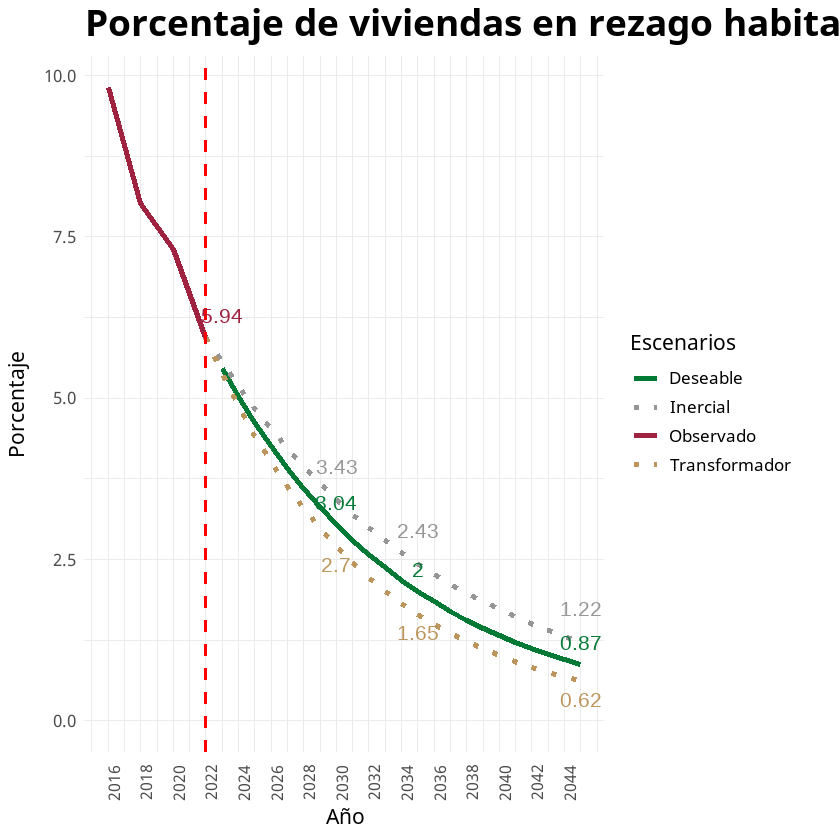

In [ ]:
grafica_bonita(
  data = prueba_desc,
  x = "year",
  y = "estimado",
  titulo = "Porcentaje de viviendas en rezago habitacional",
  ano_base = 2022,
  mostrar_etiqueta_ano_base = TRUE,
  linea_vertical = 2022,
  anios_etiquetas = c(2030, 2035, 2045),
  mostrar_intervalo = "ambos",
  fuente = "noto",
  etiqueta_x = "Año",
  etiqueta_y = "Porcentaje",
  mostrar_leyenda = TRUE,
  nombre_observado = "Observado",
  nombre_estimado_futuro = "Deseable",
  nombre_intervalo_superior = "Inercial",
  nombre_intervalo_inferior = "Transformador",
  titulo_leyenda = "Escenarios",
  limite_inferior_y = 0
)

#Salvar grafica
ggsave(
  filename = "rezago_p1.png",
  plot = last_plot(),
  width = 10,
  height = 6,
  dpi = 150,
  bg= "white"
)

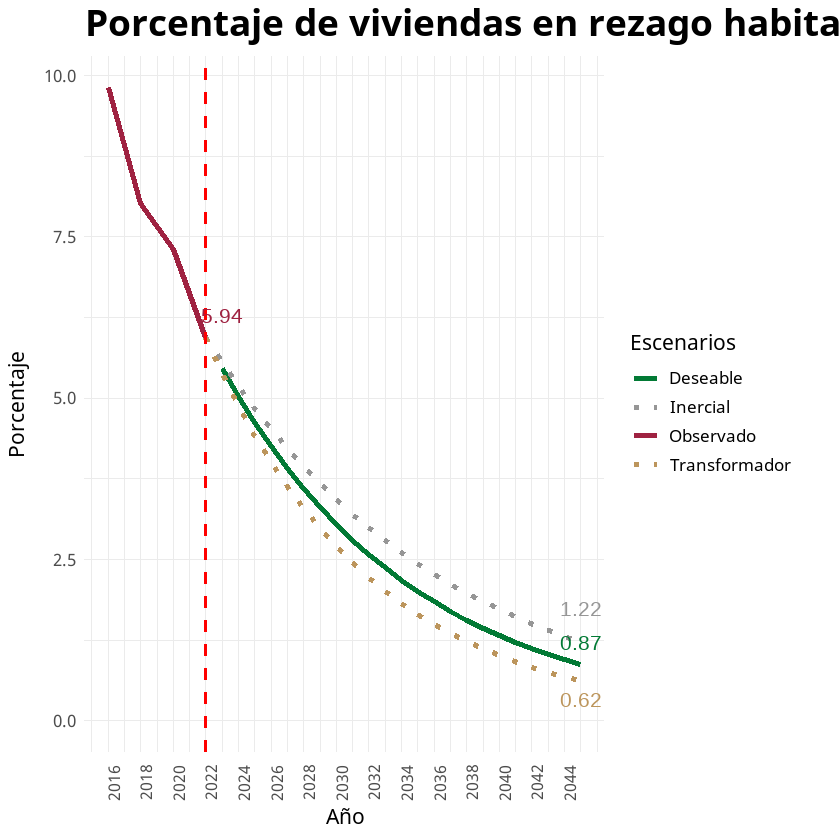

In [24]:
grafica_cool(
  data = prueba_desc,
  x = "year",
  y = "estimado",
  titulo = "Porcentaje de viviendas en rezago habitacional",
  ano_base = 2022,
  mostrar_etiqueta_ano_base = TRUE,
  linea_vertical = 2022,
  anios_etiquetas = c(2045),
  mostrar_intervalo = "ambos",
  fuente = "noto",
  etiqueta_x = "Año",
  etiqueta_y = "Porcentaje",
  mostrar_leyenda = TRUE,
  nombre_observado = "Observado",
  nombre_estimado_futuro = "Deseable",
  nombre_intervalo_superior = "Inercial",
  nombre_intervalo_inferior = "Transformador",
  titulo_leyenda = "Escenarios",
  limite_inferior_y = 0
)

#Salvar grafica
ggsave(
  filename = "rezago_p2.png",
  plot = last_plot(),
  width = 10,
  height = 6,
  dpi = 150, bg="white"
)

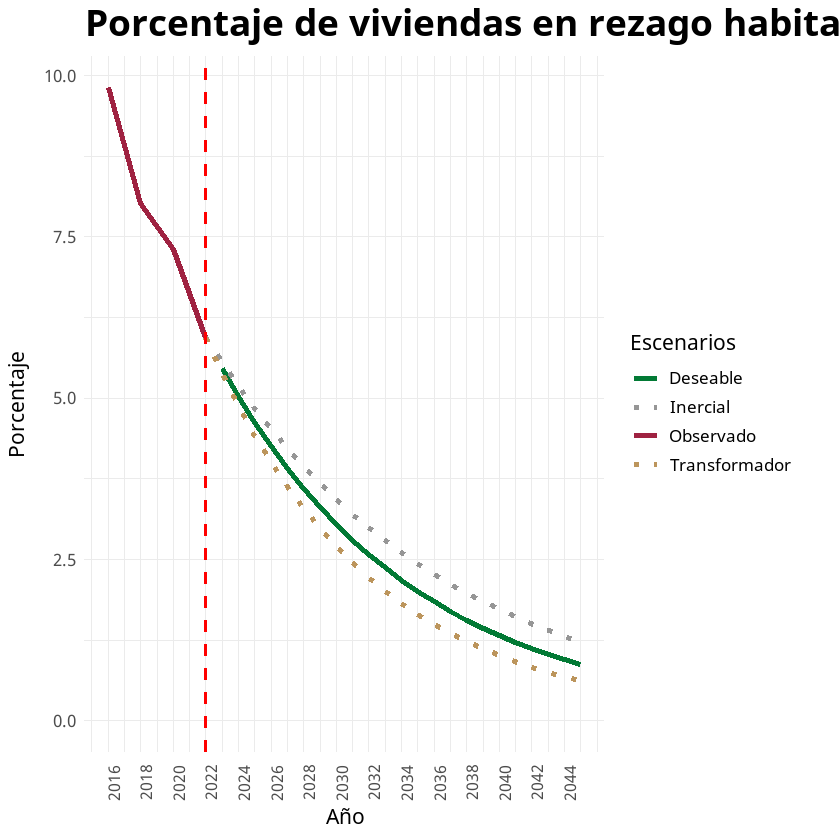

In [25]:
grafica_cool(
  data = prueba_desc,
  x = "year",
  y = "estimado",
  titulo = "Porcentaje de viviendas en rezago habitacional",
  ano_base = 2022,
  mostrar_etiqueta_ano_base = FALSE,
  linea_vertical = 2022,
  anios_etiquetas = c(),
  mostrar_intervalo = "ambos",
  fuente = "noto",
  etiqueta_x = "Año",
  etiqueta_y = "Porcentaje",
  mostrar_leyenda = TRUE,
  nombre_observado = "Observado",
  nombre_estimado_futuro = "Deseable",
  nombre_intervalo_superior = "Inercial",
  nombre_intervalo_inferior = "Transformador",
  titulo_leyenda = "Escenarios",
  limite_inferior_y = 0
)

#Salvar grafica
ggsave(
  filename = "rezago_p3.png",
  plot = last_plot(),
  width = 10,
  height = 6,
  dpi = 150, bg="white"
)

#### Ascendente

In [26]:
dir.create('data/envipe', showWarnings = FALSE)
url_1 <- 'https://www.inegi.org.mx/contenidos/programas/envipe/'
url_2 <- '/microdatos/bd_envipe_'
years <- c(2020:2024)
data_list <- list()

In [27]:
# Ciclo 1: Descarga y descompresión
for (i in 1:length(years)) {
    if (years[i] %in% c(2024)) {
        fin <- '_csv.zip'
    } else {
        fin <- '_dbf.zip'
    }

    url <- paste0(url_1, years[i], url_2, years[i], fin)
    destfile <- paste0('data/envipe/', years[i], fin)
    folder <- paste0('data/envipe/', years[i])

    dir.create(folder, showWarnings = FALSE)

    tryCatch(
        {
            options(timeout = 9999999)
            download.file(url, destfile, mode = 'wb')
        },
        error = function(e) {
            message('Error en la descarga: ', e)
        }
    )

    unzip_result <- tryCatch(
        {
            unzip(destfile, exdir = folder)
            TRUE
        },
        error = function(e) {
            message('Error en la descompresión: ', e)
            FALSE
        }
    )

    if (unzip_result) {
        print(paste('Archivos descomprimidos para el año', years[i]))

        # Eliminar el archivo ZIP después de la descompresión
        tryCatch(
            {
                file.remove(destfile)
                print(paste('Archivo eliminado:', destfile))
            },
            error = function(e) {
                message('Error al eliminar el archivo:', e)
            }
        )
    }
}


[1] "Archivos descomprimidos para el año 2020"
[1] "Archivo eliminado: data/envipe/2020_dbf.zip"
[1] "Archivos descomprimidos para el año 2021"
[1] "Archivo eliminado: data/envipe/2021_dbf.zip"
[1] "Archivos descomprimidos para el año 2022"
[1] "Archivo eliminado: data/envipe/2022_dbf.zip"
[1] "Archivos descomprimidos para el año 2023"
[1] "Archivo eliminado: data/envipe/2023_dbf.zip"
[1] "Archivos descomprimidos para el año 2024"
[1] "Archivo eliminado: data/envipe/2024_csv.zip"


In [28]:
estima_inseguridad <- function(year, variable) {

# Definir rutas
if  (year %in% c(2020:2021)) {
    ruta_base <- paste0('data/envipe/',year,'/bd_envipe_', year, '_dbf/')
}else {
    ruta_base <- paste0('data/envipe/', year, '/')
}


#Leer datos
if (year %in% c(2020:2023)) {
    seguridad <- read.dbf(paste0(ruta_base, 'TPer_Vic1.dbf'))

} else {
    seguridad <- read_csv(paste0(ruta_base, 'TPer_Vic1.csv'))
}

seguridad<-seguridad%>%
    janitor::clean_names()%>%
    mutate(fac_ele=as.numeric(fac_ele), sexo=as.numeric(sexo))

#Crear diseño muestral
dm<-seguridad%>%
    as_survey_design(
    weights = fac_ele,
    ids = upm_dis,
    strata = est_dis,
    nest = TRUE
    )


  #Estimar percepción de inseguridad de mujeres en la Ciudad de México
    confianza_fgj<-dm %>%
    filter(cve_ent == "09") %>%
filter(ap5_3_06==1)%>%
  mutate(confianza=case_when(
    ap5_4_06 %in% c(1,2) ~ "Confiable",
    TRUE ~ "No confiable")) %>%
  group_by(confianza) %>%
  summarise(
    pob = survey_total(vartype = "cv"),
    porcentaje = survey_prop(vartype = "cv")
  ) %>% mutate(porcentaje = porcentaje * 100)%>%
  filter(confianza== "Confiable")%>%
    mutate(year = year)


  #Estimar percepción de inseguridad de mujeres en la Ciudad de México
    confianza_policia<-dm %>%
    filter(cve_ent == "09") %>%
filter(ap5_3_03==1)%>%
  mutate(confianza=case_when(
    ap5_4_03 %in% c(1,2) ~ "Confiable",
    TRUE ~ "No confiable")) %>%
  group_by(confianza) %>%
  summarise(
    pob = survey_total(vartype = "cv"),
    porcentaje = survey_prop(vartype = "cv")
  ) %>% mutate(porcentaje = porcentaje * 100)%>%
  filter(confianza== "Confiable")%>%
    mutate(year = year)



  # Devolver el resultado basado en la variable
  if (variable == "confianza_fgj") {
    return(confianza_fgj)

  } else if (variable == "confianza_policia") {
    return(confianza_policia)
  }

else {
    stop("Variable no reconocida.")
  }

}

In [29]:
print("Porcentaje de personas de 18 años y más que consideran que la fiscalía es confiable")
tabla_confianza_fgj<-map_dfr(2021:2024, function(year) {
    estima_inseguridad(year, variable = "confianza_fgj")
    })
tabla_confianza_fgj

[1] "Porcentaje de personas de 18 años y más que consideran que la fiscalía es confiable"


New names:
• `` -> `...1`
Rows: 89630 Columns: 232
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (21): ID_VIV, ID_HOG, ID_PER, UPM, VIV_SEL, HOGAR, RESUL_H, R_SEL, AREA...
dbl (211): ...1, SEXO, EDAD, AP4_1, AP4_2_01, AP4_2_02, AP4_2_03, AP4_2_04, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


confianza,pob,pob_cv,porcentaje,porcentaje_cv,year
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Confiable,1419285,0.03700267,38.29989,0.02906365,2021
Confiable,1332158,0.03890160,34.67183,0.03262677,2022
Confiable,1512065,0.03589746,38.63385,0.02850885,2023
Confiable,1336158,0.03962655,38.16130,0.03159721,2024


In [30]:
tcma_confianza_fgj<-((tabla_confianza_fgj$porcentaje[tabla_confianza_fgj$year==2023]/tabla_confianza_fgj$porcentaje[tabla_confianza_fgj$year==2021])^(1/(2023-2021))-1)
tcma_confianza_fgj

[1] 0.004350347

In [31]:
extendido_confianza_fgj<-data.frame(year=2025:2045)

extendido_confianza_fgj$porcentaje<-tabla_confianza_fgj$porcentaje[tabla_confianza_fgj$year==2024]*cumprod(rep(1+tcma_confianza_fgj,length(2025:2045)))
# Paso 2: Calcular el porcentaje en 2045 según el modelo actual
porcentaje_2045 <- extendido_confianza_fgj$porcentaje[extendido_confianza_fgj$year == 2045]

# Paso 3: Calcular el factor de ajuste
factor_ajuste <- 50 / porcentaje_2045
factor_ajuste
# Paso 4: Aplicar el factor de ajuste solo a los últimos dos años de la serie
extendido_confianza_fgj$porcentaje[extendido_confianza_fgj$year >= 2044] <-
    extendido_confianza_fgj$porcentaje[extendido_confianza_fgj$year >= 2044] * factor_ajuste

# Redondear los resultados
extendido_confianza_fgj %>%
    mutate(porcentaje = round(porcentaje, 2))

[1] 1.196071

year,porcentaje
<int>,<dbl>
2025,38.33
2026,38.49
2027,38.66
2028,38.83
2029,39.00
2030,39.17
2031,39.34
2032,39.51
2033,39.68


In [32]:
prueba_asc<-tabla_confianza_fgj%>%
select(year, porcentaje)%>%
intervals("porcentaje", margen = 0, año_base = 2024)

extendido_confianza_fgj_int<-extendido_confianza_fgj%>%
intervals("porcentaje", margen = 0.01, año_base = 2024)

prueba_asc<-prueba_asc%>%
bind_rows(extendido_confianza_fgj_int)
prueba_asc

year,estimado,superior,inferior
<dbl>,<dbl>,<dbl>,<dbl>
2021,38.29989,38.29989,38.29989
2022,34.67183,34.67183,34.67183
2023,38.63385,38.63385,38.63385
2024,38.16130,38.16130,38.16130
2025,38.32731,38.71059,37.94784
2026,38.49405,39.26778,37.73557
2027,38.66151,39.83300,37.52448
2028,38.82971,40.40635,37.31458
2029,38.99863,40.98795,37.10586


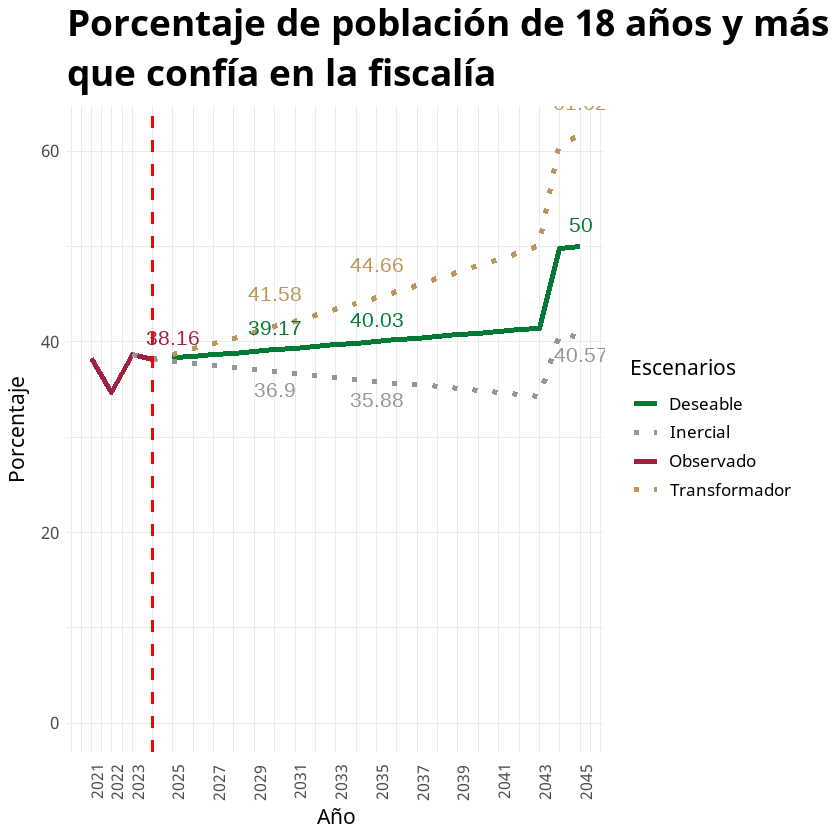

In [33]:
grafica_cool(
  data = prueba_asc,
  x = "year",
  y = "estimado",
  titulo = "Porcentaje de población de 18 años y más
que confía en la fiscalía",
  ano_base = 2024,
  mostrar_etiqueta_ano_base = TRUE,
  linea_vertical = 2024,
  anios_etiquetas = c(2030, 2035, 2045),
  mostrar_intervalo = "ambos",
  fuente = "noto",
  etiqueta_x = "Año",
  etiqueta_y = "Porcentaje",
  mostrar_leyenda = TRUE,
  nombre_observado = "Observado",
  nombre_estimado_futuro = "Deseable",
  nombre_intervalo_superior = "Transformador",
  nombre_intervalo_inferior = "Inercial",
  titulo_leyenda = "Escenarios",
  limite_inferior_y = 0
)

#Salvar grafica
ggsave(
  filename = "confianza_fgj_p1.png",
  plot = last_plot(),
  width = 10,
  height = 6,
  dpi = 185, bg="white"
)

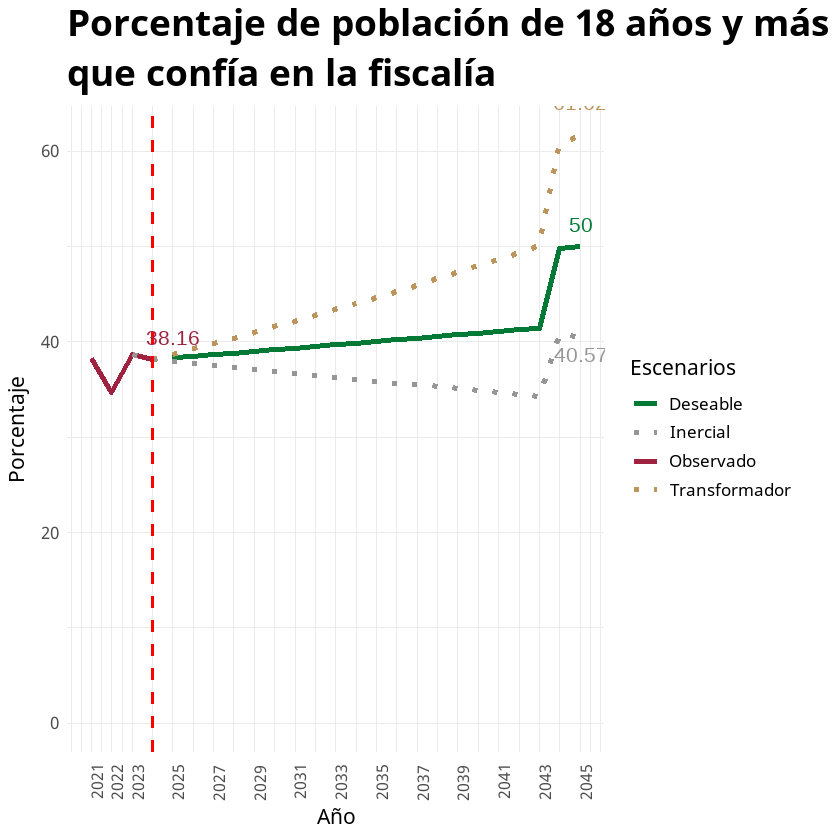

In [34]:
grafica_cool(
  data = prueba_asc,
  x = "year",
  y = "estimado",
  titulo = "Porcentaje de población de 18 años y más
que confía en la fiscalía",
  ano_base = 2024,
  mostrar_etiqueta_ano_base = TRUE,
  linea_vertical = 2024,
  anios_etiquetas = c(2045),
  mostrar_intervalo = "ambos",
  fuente = "noto",
  etiqueta_x = "Año",
  etiqueta_y = "Porcentaje",
  mostrar_leyenda = TRUE,
  nombre_observado = "Observado",
  nombre_estimado_futuro = "Deseable",
  nombre_intervalo_superior = "Transformador",
  nombre_intervalo_inferior = "Inercial",
  titulo_leyenda = "Escenarios",
  limite_inferior_y = 0
)

#Salvar grafica
ggsave(
  filename = "confianza_fgj_p2.png",
  plot = last_plot(),
  width = 10,
  height = 6,
  dpi = 185, bg="white"
)

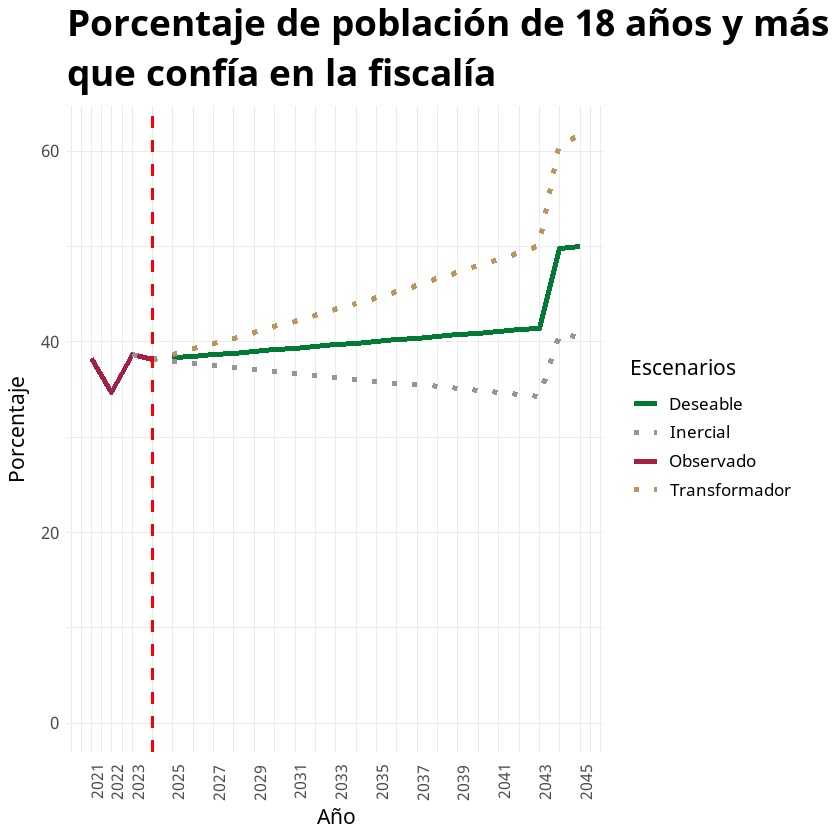

In [35]:
grafica_cool(
  data = prueba_asc,
  x = "year",
  y = "estimado",
  titulo = "Porcentaje de población de 18 años y más
que confía en la fiscalía",
  ano_base = 2024,
  mostrar_etiqueta_ano_base = FALSE,
  linea_vertical = 2024,
  anios_etiquetas = c(),
  mostrar_intervalo = "ambos",
  fuente = "noto",
  etiqueta_x = "Año",
  etiqueta_y = "Porcentaje",
  mostrar_leyenda = TRUE,
  nombre_observado = "Observado",
  nombre_estimado_futuro = "Deseable",
  nombre_intervalo_superior = "Transformador",
  nombre_intervalo_inferior = "Inercial",
  titulo_leyenda = "Escenarios",
  limite_inferior_y = 0
)

#Salvar grafica
ggsave(
  filename = "confianza_fgj_p3.png",
  plot = last_plot(),
  width = 10,
  height = 6,
  dpi = 185, bg="white"
)